### Large Language Model Introduction

LLMs are a wide variety of model architecture - only a few end with chat agents
- work with embeddings (dense representation of text)
- trained on large amount of text/tokens with neural network


Pretrained model: generalized representation of text trained on billions of tokens
- Fine tune pretrained model for individual tasks
- Trained on next token prediction (guess what token should be generated next)



In [ ]:
# Change runtime to GPU to run large computations to maintain decent performance speed
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#!virtualenv /content/drive/MyDrive/colab_env
#!source /content/drive/MyDrive/colab_env/bin/activate; pip install datasets evaluate accelerate

In [ ]:
# add path of virtual environment site-packages to system path
import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")

In [ ]:
# !pip3 install torch torchvision

import torch # similar to numpy, have more additions like gradients (allow model to perform backpropagation when training)
from transformers import AutoTokenizer, AutoModel


HuggingFace: community with public models & datasets
- Model represented in binary chunks of data
- Transformers: coordinate all moving parts

Google Bert (bert base uncased):
- BERT - bidirectional encoder
- Model name: checkpoint of when pretraining ended
- Built on transformer

In [ ]:
# Model pulled from Huggingface (cloud)
checkpoint = 'google-bert/bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert = AutoModel.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# NLP Recap

### Tokenization

In traditional tokenization and model building, we can set a cutoff below which rare tokens could be ignored, but LLMs need all text. That means they need to represent every token in a corpus - without storing representations for every token in a corpus.

Breaking up string along white spaces into individual units
- Text needs to be tokenized for modeling

LLMs use **subword tokenization** - model breaks up some words into smaller segments, not along whitespace
- use subset of all possible tokens in corpus, reserving morphine like units for rarer word
- rare tokens can cause a lot of trouble for models
- developers set cut-off point of what should be a tokenizer
  - Tokenizer is a trained model

This way, a model can literally spell out any text sequence it needs to build without having representations for every unique token in its training corpus.

LLMs are modeling models



In [ ]:
phrase = 'large language models use subword tokenization'

In [ ]:
token = tokenizer(phrase)
tokenizer.decode(token['input_ids'])

'[CLS] large language models use subword tokenization [SEP]'

In [ ]:
for tokid in token['input_ids']:
  token = tokenizer.decode(tokid)
  print(token)


[CLS]
large
language
models
use
sub
##word
token
##ization
[SEP]


In [ ]:
sentence = "Then I tried to find some way of embracing my mother's ghost."

# return type - pytorch tensors
inputs = tokenizer(sentence, return_tensors='pt', return_attention_mask = True)
inputs

{'input_ids': tensor([[  101,  2059,  1045,  2699,  2000,  2424,  2070,  2126,  1997, 23581,
          2026,  2388,  1005,  1055,  5745,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
tokenizer.decode(5745)

'ghost'

input_ids: unique ID a model uses to pull token

Use the .decode() method to transform an ID (or sequences of ids) back to text.

Bert style model:
[CLS]: marks the start of a sequence - acts as a summary token for the sequence
[SEP]: marks the end of a sequence
* Used to send multiple sequence to model at the same time - use [SEP]
  * Eg. QnA using [SEP] to seperate






In [ ]:
inputs["token_type_ids"]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Some models don’t need anything more than [CLS] and [SEP] to make the above distinctions. But other models also incorporate **token type IDs** to further distinguish individual pieces of input. These IDs are binary values that tell the model which parts of the input belong to what components in the task.

In [ ]:
question = "What did I do then?"
with_token_types = tokenizer(question, sentence)
with_token_types["token_type_ids"]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
inputs["attention_mask"]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

A final output, **attention mask**, tells the model what part of the input it should use when it processes the sequence.

### Padding

It may seem like a redundancy to add an attention mask, but tokenizers often pad input sequences. While Transformer models can process sequences in parallel, which massively speeds up their run time, each sequence in a batch needs to be the **same length**. Texts, however, are rarely the same length, hence the padding.

In [ ]:
two_sequence_inputs = tokenizer(
    [question, sentence],
    return_tensors = "pt",
    return_attention_mask = True,
    padding = "longest"
)
two_sequence_inputs["input_ids"]

tensor([[  101,  2054,  2106,  1045,  2079,  2059,  1029,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  2059,  1045,  2699,  2000,  2424,  2070,  2126,  1997, 23581,
          2026,  2388,  1005,  1055,  5745,  1012,   102]])

"longest"
Token ID 0 is the [PAD] token.



In [ ]:
two_sequence_inputs["attention_mask"]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

There are a few different strategies for padding. Above, we had the tokenizer pad to the longest sequence in the input. But usually it’s best to set it to max_length:

In [ ]:
two_sequence_inputs = tokenizer(
    [question, sentence],
    return_tensors = "pt",
    return_attention_mask = True,
    padding = "max_length"
)
two_sequence_inputs["input_ids"][0]

tensor([ 101, 2054, 2106, 1045, 2079, 2059, 1029,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [ ]:
# This will pad the text out to the maximum number of tokens the model can process at once.
# This number is known as the context window.

print("Context window size:", tokenizer.model_max_length)

# largest context window BERT can handle
# need to make sure input size does not exceed context window

Context window size: 512


In [ ]:
too_long = "a " * 10_000
too_long_inputs = tokenizer(
    too_long, return_tensors = "pt", return_attention_mask = True
)

Token indices sequence length is longer than the specified maximum sequence length for this model (10002 > 512). Running this sequence through the model will result in indexing errors


### Truncation
Set truncation to True to avoid this problem (token indices sequence length too long).

In [ ]:
too_long_inputs = tokenizer(
    too_long,
    return_tensors = "pt",
    return_attention_mask = True,
    padding = "max_length",
    truncation = True
)

In [ ]:
len(too_long_inputs["input_ids"].squeeze())

512

In [ ]:
device = 0 if torch.cuda.is_available() else "cpu"
bert.to(device)

print("Moved model to", device)

Moved model to 0


In [ ]:
# or set the model device when initializing it
#model = AutoModel.from_pretrained(checkpoint, device = device)

### Model in evaluation mode to process inputs

* Static embeddings - word2vec
* Dynamic embeddings - LLMs

In [ ]:
# Evaluation mode - more deterministic (turn off layers of randomness)
## to get more expected outputs
bert.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Then, wrap the process in a context manager. This context manager will keep the model from collecting gradients when it processes. Unless you are training a model or trying understand model internals, there’s no need for gradients. With the context manager built, send the inputs to the model.

Gradients take up memory

In [ ]:
# Assuming 'device' is defined as 'torch.device("cuda")' if a GPU is available
inputs = {k: v.to(device) for k, v in inputs.items()} # Move inputs to the same device as the model

with torch.no_grad():
    outputs = bert(**inputs, output_hidden_states=True)

In [ ]:
# tensor that is stored in outputs
# contain set of weights for final layer in network for every single token
outputs.last_hidden_state.shape

torch.Size([1, 17, 768])

In [ ]:
# tensor for CLS token (summary token)
outputs.pooler_output.shape

torch.Size([1, 768])

In [ ]:
# tuple of tensors that corresponds to the output weights of embeddings for every layer of this network
outputs.hidden_states

(tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
          [-0.2008,  0.1479,  0.1878,  ...,  0.9505,  0.9427,  0.1835],
          [-0.3319,  0.4860, -0.1578,  ...,  0.5669,  0.7301,  0.1399],
          ...,
          [-0.1509,  0.1222,  0.4894,  ...,  0.0128, -0.1437, -0.0780],
          [-0.3884,  0.6414,  0.0598,  ...,  0.6821,  0.3488,  0.7101],
          [-0.5870,  0.2658,  0.0439,  ..., -0.1067, -0.0729, -0.0851]]],
        device='cuda:0'),
 tensor([[[-0.0422,  0.0229, -0.2086,  ...,  0.1785, -0.0790, -0.0525],
          [-0.5901,  0.1755, -0.0278,  ...,  1.0815,  1.6212,  0.1523],
          [ 0.0323,  0.8927, -0.2348,  ...,  0.0032,  1.3259,  0.2274],
          ...,
          [ 0.6683,  0.2020, -0.0523,  ...,  0.0027, -0.2793,  0.1329],
          [-0.1310,  0.5102, -0.1028,  ...,  0.3445,  0.0718,  0.6305],
          [-0.3432,  0.2476, -0.0468,  ..., -0.1301,  0.1246,  0.0411]]],
        device='cuda:0'),
 tensor([[[-0.1382, -0.2264, -0.4627,  ...,  0.351

### Which layer? Which token?

Classification task with BERT: modifying the network layers to output one of a set of labels for input. All this will happen inside the model itself, but it’s also perfectly fine to generate embeddings with a model and to use those embeddings for some other task that has nothing to do with a LLM.

People often use the last **hidden state embeddings** for other tasks, though there’s no hard and fast rule saying that this is necessary. The BERTology paper tells us that different layers in BERT do different things: earlier ones capture syntactic features, while later ones capture more semantic features. If you’re studying syntax, you might choose an earlier layer, or set of layers.

For general document embeddings, there are a number of options:

* Instead of using the [CLS] token, **mean pooling** involves computing the mean of all tokens in the last hidden layer. This can potentially smooth out noise

* **Max pooling** takes the max of all tokens’ last hidden layer embeddings. This boosts salient (outlier) features in a sequence

* Other people compute the **mean of the last four layers and select [CLS]** from that (though you could use all tokens, too); others take the sum of the last four layers. Both strategies combine information from a greater portion of the model

* **A concatenation of the last four layers** (like appending layers in a list) is yet another option. This can potentially combine different levels of abstraction

Early layers = syntax

Later layers = semantics

One of the reasons [CLS] is customary is because this token is in every input sequence.

In [ ]:
# Sentence transformer library -> n dimensional embeddings for every input sequence (dynamic)
##handle many of these pooling operations

# Google BERT model for Genre Classification

### Import libraries

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    AutoModel
)
from transformers import (
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from transformers import pipeline, GenerationConfig
import evaluate
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import accelerate

### Fine-Tuning a BERT Model

In [ ]:
blurbs = pd.read_parquet("/content/drive/MyDrive/LLM_data/bert_blurb_classifier/blurbs.parquet")

In [ ]:
blurbs["d1"].sample(5).tolist()

['Graphic Novels & Manga',
 'Cooking',
 'Biography & Memoir',
 'Biography & Memoir',
 'Children’s Middle Grade Books']

In [ ]:
# convert string to unique ID
enumerated = list(enumerate(blurbs["d1"].unique()))
id2label = {idx: genre for idx, genre in enumerated}
label2id = {genre: idx for idx, genre in enumerated}

blurbs["label"] = blurbs["d1"].replace(label2id)

In [ ]:
num_labels = blurbs["label"].nunique()
print(num_labels, "unique labels")

10 unique labels


In [ ]:
blurbs.value_counts("label")

label
0    1459
1    1459
2    1459
3    1459
4    1459
5    1459
6    1459
7    1459
8    1459
9    1459
Name: count, dtype: int64

In [ ]:
# Dataset library - optimized library for tabular data for transformers
##work directly with the Hugging Face training pipeline to handle batch processing and other such optimizations in an automatic fashion
dataset = Dataset.from_pandas(blurbs[["text", "label"]])
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 14590
})

In [ ]:
dataset = Dataset.from_pandas(blurbs[["text", "label"]])
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 14590
})

Load a model to fine-tune. This works just like we did earlier, though the AutoModelForSequenceClassification object expects to have an argument that specifies how many labels you want to train your model to recognize.

AutomodelforSequenceClassification
- Base BERT model + linear layer

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels = num_labels
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# associate the label mappings
model.config.id2label = id2label
model.config.label2id = label2id

Data preparation to tokens

In [ ]:
def tokenize(examples):
    """Tokenize strings.

    Parameters
    ----------
    examples : dict
        Batch of texts

    Returns
    -------
    tokenized : dict
        Tokenized texts
    """
    tokenized = tokenizer(examples["text"], truncation = True)

    return tokenized

In [ ]:
split = dataset.train_test_split()
split

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10942
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3648
    })
})

In [ ]:
trainset = split["train"].map(tokenize, batched = True)
testset = split["test"].map(tokenize, batched = True)

trainset

Map:   0%|          | 0/10942 [00:00<?, ? examples/s]

Map:   0%|          | 0/3648 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10942
})

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

### Logging

Logging training progress to monitor how a model is doing while it trains. The function below computes metrics when the model pauses to perform an evaluation. During evaluation, the model trainer will call this function, calculate the scores, and display the results.

In [ ]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(evaluations):
    """Compute metrics for a set of predictions.

    Parameters
    ----------
    evaluations : tuple
        Model logits/label for each text and texts' true labels

    Returns
    -------
    scores : dict
        The metric scores
    """
    # Split the model logits from the true labels
    logits, references = evaluations

    # Find the model prediction with the maximum value
    predictions = np.argmax(logits, axis = 1)

    # Calculate the scores
    accuracy = accuracy_metric.compute(
        predictions = predictions, references = references
    )
    f1 = f1_metric.compute(
        predictions = predictions,
        references = references,
        average = "weighted"
    )

    # Wrap up the scores and return them for display during logging
    scores = {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}

    return scores

### Training hyperparameters

epochs: no. times model sees entire data

batch size: how much model sees at each step (32-64)

step: when model update parameters
* too small step size - combat memory problems; does not let model generalize (eg. anomalies)
* too large step size - no specificity, too general

learning rate: how quickly model fits to data (the amount by which the model updates its weights at each step)


In [ ]:
#num_train_epochs = 15
#per_device_train_batch_size = 32
#per_device_eval_batch_size = 8
#learning_rate = 3e-5

num_train_epochs = 5
per_device_train_batch_size = 16
per_device_eval_batch_size = 4
learning_rate = 5e-5

When learning rate is too high - too drastic update early in training leads to sub-optimally fitted model

**Warm up steps:** help stabilize a model’s final parameters by gradually increasing the learning rate over a set number of steps.
*  use 10% of your total training steps as the step size for warm up

In [ ]:
warmup_steps = (len(trainset) / per_device_train_batch_size) * num_train_epochs
warmup_steps = round(warmup_steps * 0.1)
print("Number of warm up steps:", warmup_steps)

Number of warm up steps: 342


**Weight decay**: helps prevent overfitted models by keeping model weights from growing too large
* a penalty value added to the loss function
* use a higher value for smaller datasets

In [ ]:
weight_decay = 1e-2

In [ ]:
training_args = TrainingArguments(
    output_dir = "/content/drive/MyDrive/LLM_data/bert_blurb_classifier",
    num_train_epochs = num_train_epochs,
    per_device_train_batch_size = per_device_train_batch_size,
    per_device_eval_batch_size = per_device_eval_batch_size,
    learning_rate = learning_rate,
    warmup_steps = warmup_steps,
    weight_decay = weight_decay,
    logging_steps = 100,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    load_best_model_at_end = True,
    metric_for_best_model = "loss",
    save_total_limit = 3,
    push_to_hub = False
)

### Model Training

In [ ]:
trainer = Trainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = data_collator,
    args = training_args,
    train_dataset = trainset,
    eval_dataset = testset,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = 3)] # after 3 epochs, model hasn't improved, cut early to prevent overfitting
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.556000,0.488711,0.845943,0.845623
2,0.350600,0.442934,0.868421,0.867987
3,0.192300,0.593594,0.866776,0.868113
4,0.055800,0.624847,0.879934,0.879272


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.556000,0.488711,0.845943,0.845623
2,0.350600,0.442934,0.868421,0.867987
3,0.192300,0.593594,0.866776,0.868113
4,0.055800,0.624847,0.879934,0.879272
5,0.027400,0.660086,0.879112,0.879081


TrainOutput(global_step=3420, training_loss=0.309641531724156, metrics={'train_runtime': 4890.5008, 'train_samples_per_second': 11.187, 'train_steps_per_second': 0.699, 'total_flos': 1.2849803307836544e+16, 'train_loss': 0.309641531724156, 'epoch': 5.0})

In [ ]:
trainer.save_model("LLM_data/bert_blurb_classifier/final")

### Model Evaluation

Look at classification accuracy, then token influence

In [ ]:
fine_tuned = "LLM_data/bert_blurb_classifier/final"
tokenizer = AutoTokenizer.from_pretrained(fine_tuned)
model = AutoModelForSequenceClassification.from_pretrained(fine_tuned)

In [ ]:
# Pipeline
classifier = pipeline(
    "text-classification", model = model, tokenizer = tokenizer
)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
sample = blurbs.sample(1)
result ,= classifier(sample["text"].item())
print(f"Model label: {result['label']} ({result['score']:.2f}% conf.)")
print("Actual label:", sample["d1"].item())

Model label: Graphic Novels & Manga (1.00% conf.)
Actual label: Graphic Novels & Manga


In [ ]:
classifier(sample["text"].item(), top_k = None)

[{'label': 'Graphic Novels & Manga', 'score': 0.996335506439209},
 {'label': 'Children’s Middle Grade Books', 'score': 0.0015339874662458897},
 {'label': 'Arts & Entertainment', 'score': 0.000638989033177495},
 {'label': 'Mystery & Suspense', 'score': 0.0003216357436031103},
 {'label': 'Religion & Philosophy', 'score': 0.0002587730414234102},
 {'label': 'Politics', 'score': 0.00025382914463989437},
 {'label': 'Cooking', 'score': 0.00022764448658563197},
 {'label': 'Romance', 'score': 0.0001521087106084451},
 {'label': 'Literary Fiction', 'score': 0.00015146975056268275},
 {'label': 'Biography & Memoir', 'score': 0.0001259893033420667}]

### Classification Accuracy


In [ ]:
sample = blurbs.sample(250)
predicted = classifier(sample["text"].tolist(), truncation = True)

In [ ]:
y_true = sample["d1"].tolist()
y_pred = [prediction["label"] for prediction in predicted]
report = classification_report(y_true, y_pred, zero_division = 0.0)
print(report)

                               precision    recall  f1-score   support

         Arts & Entertainment       1.00      0.95      0.97        19
           Biography & Memoir       0.88      0.88      0.88        25
Children’s Middle Grade Books       1.00      0.95      0.97        20
                      Cooking       1.00      1.00      1.00        26
       Graphic Novels & Manga       1.00      1.00      1.00        23
             Literary Fiction       0.91      0.88      0.89        24
           Mystery & Suspense       0.88      0.96      0.92        24
                     Politics       1.00      0.85      0.92        26
        Religion & Philosophy       0.83      1.00      0.91        29
                      Romance       0.94      0.91      0.93        34

                     accuracy                           0.94       250
                    macro avg       0.94      0.94      0.94       250
                 weighted avg       0.94      0.94      0.94       250



In [ ]:
confusion = confusion_matrix(y_true, y_pred)
confusion = pd.DataFrame(
    confusion, columns = label2id.keys(), index = label2id.keys()
)

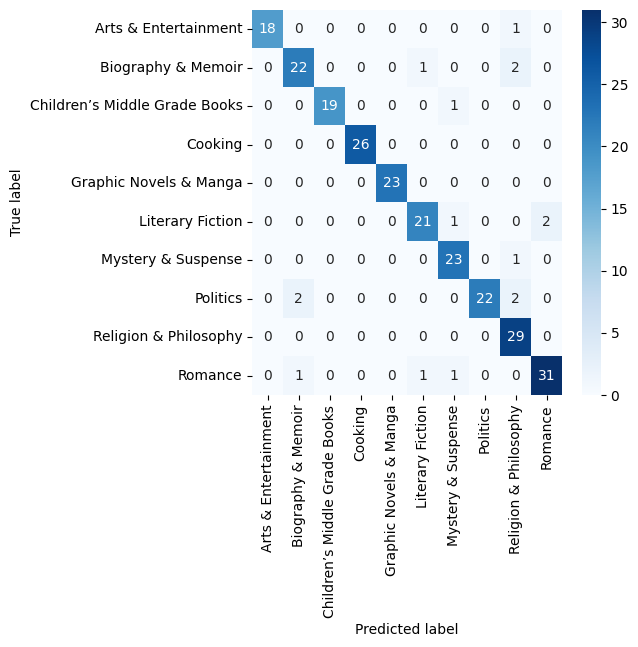

In [ ]:
fig, ax = plt.subplots(figsize = (5, 5))
g = sns.heatmap(confusion, annot = True, cmap = "Blues", ax = ax);
ax.set(ylabel = "True label", xlabel = "Predicted label")
plt.show()